## import

In [1]:
import csv
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import pyreadr
import matplotlib
from tqdm import tqdm
from scipy import stats

## setup params

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 16

In [3]:
notvalid = [x for x in range(34,41)]
notvalid.extend([9,20,25,42])
valid_patients_pupil = [ele for ele in range(1,56) if ele not in notvalid]

notvalid = [x for x in range(34,41)]
notvalid.append(9)
valid_patients_eda = [ele for ele in range(1,56) if ele not in notvalid]

valid_pupil_eda = list(set(valid_patients_eda).intersection(set(valid_patients_pupil)))

notvalid = [x for x in range(34, 41)]
notvalid= notvalid + [9,11,12,20]
valid_patients_hr = [ele for ele in range(1, 56) if ele not in notvalid]

## global var

In [4]:
NUM_TRIALS = 160

## heart rate functions

In [5]:
def extract_hr_by_subject(subject_number: int) -> pd.DataFrame:
    """
    Extract heart data of the subject (reading tmp_hr csv files in tmp_hr folder) and return same data in one list
    :param subject_number:
    :return:
    """
    if subject_number not in valid_patients_hr:
        print('subject number not valid, probably this patient has not valid hr signals')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str("tmp_eda/tmp_eda" + str(subject_number) + ".csv")
    pat_ = pd.read_csv(path_csv)
    df = {'subject': subject_number, 'hr': pat_['CH2'], 'trigger': pat_['CH28']}
    return pd.DataFrame(df)


def all_subject_hr() -> pd.DataFrame:
    """
    Create a single dataframe containing all the hr values of all subjects
    :return:
    """
    generic_df = pd.DataFrame(columns=['subject', 'hr', 'trigger'])
    for i in tqdm(valid_patients_hr):
        df_ = modified_hr_by_subject(i)
        #df_['time'] = np.arange(0, len(signals) / 100, 0.01)[:len(df_)] #no sense sta cosa ma senza non va
        generic_df = pd.concat([generic_df, df_], axis=0)
    return generic_df

'''
def modified_hr_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the hr from the given subjects and applies some changes: NO ACTION now
    :param subject:
    :return: new Dataframe with the corrected EDA values
    """
    df = extract_hr_by_subject(subject)
    return df
'''

def modified_hr_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the hr from the given subjects and applies NOTHING
    :param subject:
    :return: new Dataframe with the corrected hr values
    """
    df_ = extract_hr_by_subject(subject)
    df_ = add_latency(df_, -250,500) #TODO INSERT CORRECT VALUE OF LATENCY
    return df_


## pupil functions

In [6]:
def read_csv_pupil_raw(subject_number:int) -> pd.DataFrame:
    """
    Read pupil csv files
    :param subject_number:
    :return: A dataframe with pupil data of the subject subject_number
    """
    if subject_number not in valid_patients_pupil:
        print('subject number not valid, probably this patient has not valid pupil signals')
        return pd.DataFrame()
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    pupil1 = pd.read_csv('../osfstorage-archive/eye/pupil/Look0' + str(subject_number) + '_pupil.csv', sep=';')
    for i in pupil1.columns:
        if i != 'trial':
            for j in pupil1.index:
                pupil1.loc[j, i] = pupil1.loc[j, i].replace(',', '.')
    cols = pupil1.columns.drop('trial')

    pupil1[cols] = pupil1[cols].apply(pd.to_numeric, errors='coerce')
    return pupil1

def create_csv_pupil():
    """
    Create in current folder one tmp csv well formatted with pupil data for each subject
    :return: nothing
    """
    for subject in valid_patients_pupil:
        pupil_i = read_csv_pupil_raw(subject)
        name = 'tmp_pupil/tmp_pupil' + str(subject) + '.csv'
        pupil_i.to_csv(name, index=False)

def read_csv_pupil(subject:int) -> pd.DataFrame:
    """
    Read in current folder one tmp csv well formatted with pupil data
    :param subject:
    :return: Dataframe with pupil data of the subject
    """
    name = 'tmp_pupil/tmp_pupil'+str(subject)+'.csv'
    return pd.read_csv(name, sep=',')

def extract_pupil_by_subject(subject_number:int) -> list:
    """
    Extract pupil data of the subject and return same data in one list adding NaN values to reach same trial length of eda data
    :param subject_number:
    :return:
    """
    pupil = read_csv_pupil(subject_number)
    pupil_ = pupil.copy().drop(['trial'], axis=1)
    # convert all datas into one list
    pat1_pupil = []
    len_eda = int(len_trial_eda(subject_number))
    for i in range(160):
        raw_list = pupil_.loc[i, :].values.flatten().tolist()
        pat1_pupil = pat1_pupil + raw_list
    # pat1_pupil

    return pat1_pupil

def correct_pupil_diam(l:list)->list:
    """
    Shift the pupil diameter values
    :param l: pupil diameter list
    :return: A list containing new pupil shifted
    """
    ADD_SHIFT = -2
    MULT_SHIFT = 4
    return [(x+ADD_SHIFT)*MULT_SHIFT if x != 'NaN' else float('NaN') for x in l]

def extract_maxpupil_trial(subject: int) -> list:
    """
    Calculate the max value of pupil signal in each trial.
    :param subject:
    :return: a list with same length of the pupil signal filled with 0 or 1. 1 if the equivalent value is a max, 0 otherwise
    """
    pupil_csv = read_csv_pupil(subject)
    max_list = []
    max_length = max(700, int(len_trial_eda(subject)))
    for i in range(160):
        max_trial_list = list(pupil_csv.loc[i])[1:]
        max_ = max(max_trial_list)
        max_index = max_trial_list.index(max_)
        for j in range(max_length):
            if j == max_index:
                max_list.append(1)
            else:
                max_list.append(0)
    return max_list

def all_subject_pupil() -> pd.DataFrame:
    """
    Create a dataframe with all pupil data of all subject after adding latency
    :return: a dataframe with all pupil data of all subject with columns ['pupil_diameter', 'pupil_peak', 'subject']
    """
    generic_df = pd.DataFrame(columns=['pupil_diameter', 'subject'])
    for i in tqdm(valid_pupil_eda):
        df_ = modified_pupil_subject(i)
        generic_df = pd.concat([generic_df, df_], axis=0)

    return generic_df

def modified_pupil_subject(subject):
    # print(f'pupil: {subject}')
    person_i_all_pupil = extract_pupil_by_subject(subject)
    max_list_i = extract_maxpupil_trial(subject)
    # print(f'person: {len(person_i_all_pupil)}, max: {len(max_list_i)}')
    dict_ = {'pupil_diameter': person_i_all_pupil,
             'subject': subject}
    df_ = pd.DataFrame(dict_)
    df_ = add_latency(df_, -1000,100)
    # df_['time'] = np.arange(0, len(df_) / 100, 0.01)
    return df_


## Eda functions

In [7]:
def len_trial_eda(subject:int) -> int:
    """
    Calculate the length of the trial of the eda signal given subject number
    :param subject:
    :return: int that indicates the length
    """
    df_subject = modified_eda_by_subject(subject)
    return len(df_subject)/NUM_TRIALS

def extract_eda_by_subject(subject_number: int) -> list:
    """
    Extract eda data of the subject (reading tmp_eda csv files in current folder) and return same data in one list
    :param subject_number:
    :return:
    """
    if subject_number not in valid_patients_eda:
        print('subject number not valid, probably this patient has not valid eda signals')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str("tmp_eda/tmp_eda" + str(subject_number) + ".csv")
    pat_eda = pd.read_csv(path_csv)['CH1']
    return pat_eda.to_numpy()

def all_subject_eda() -> pd.DataFrame:
    """
    Create a single dataframe containing all the EDA values of all subjects
    :return:
    """
    generic_df = pd.DataFrame(columns=['subject', 'phasic', 'phasic_peak'])
    for i in tqdm(valid_pupil_eda):
        df_ = modified_eda_by_subject(i)
        #df_['time'] = np.arange(0, len(signals) / 100, 0.01)[:len(df_)] #no sense sta cosa ma senza non va
        generic_df = pd.concat([generic_df, df_], axis=0)
    return generic_df

def modified_eda_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the EDA from the given subjects and applies all the changes: removing last zeros from the list and the outliers at the end
    :param subject:
    :return: new Dataframe with the corrected EDA values
    """
    eda = extract_eda_by_subject(subject)
    # print(f'eda: {i}')
    #eda = resample_eda(eda)
    signals, info = nk.eda_process(eda, sampling_rate=500, method="neurokit")
    eda_phasic = signals['EDA_Phasic']
    #eda_phasic = remove_last_zeros(eda_phasic)
    #eda_phasic = remove_outliers(eda_phasic)
    df = {'subject': subject, 'phasic': eda_phasic, 'phasic_peak': signals['SCR_Peaks'][:len(eda_phasic)]}
    df_ = pd.DataFrame(df)
    df_ = add_latency(df_, -5000, 500)
    return df_


## general functions

In [8]:
def start_trial_time(df:pd.DataFrame)-> list:
    """

    :param df: a dataframe with index in position 0, colum time in position 3 and trigger in position 2
    :return: a list of time where starts trial using trigger as a rectangular activation function
    """
    start_trials = [] #TODO optimize this function.too much time
    prec = -1
    for i in tqdm(df.iterrows()):
        if i[1][2] == 5 and prec == 0:
            start_trials.append(i[1][3])
        prec = i[1][2]
    return start_trials

def resample(eda_signal:list,freq_init:int,freq_fin:int) -> list:
    """
    Change sampling rate of the eda signal from initial freq to final freq
    :param eda_signal: list of eda_signal
    :param freq_init: initial sampling rate in hz
    :param freq_fin: final sampling rate in hz
    :return: list of eda_signal with sampling rate of 100hz
    """
    if freq_fin>freq_init:
        print("error only downsample")
        return []
    factor = int(freq_fin/freq_init)
    eda_new = []
    for x in range(len(eda_signal)):
        if x % factor == 0:
            eda_new.append(eda_signal[x])
    return eda_new

def add_latency(dataframe:pd.DataFrame, msecs:int, freq:int)->pd.DataFrame:
    """
    It creates the correct 'time' column of the given dataframe.
    :param dataframe:
    :param secs:
    :param freq: sampling of the signal in Hz
    """
    freq_sec = float(1/freq)
    new_df = dataframe
    time_ = []
    first_value = msecs/1000
    for i in range(len(dataframe)):
        time_.append(first_value)
        first_value += freq_sec
    #print(len(time_))
    new_df['time'] = time_
    return new_df

def remove_outliers(l:list) -> list:
    """
    Remove outliers from a given list. An outlier is detected if its zscore exceeds a certain threshold.
    :param l: list
    :return: same list without outliers
    """
    z = np.abs(stats.zscore(l))
    THRESHOLD = 4
    PERC_LEN = 0.80
    # Position of the first outlier
    outliers = np.where(z>THRESHOLD)[0]
    for x in outliers:
        if x > PERC_LEN*len(l):
            l = l[:x]
            break
    '''
    for x in outliers:
        if x < (1-PERC_LEN)*len(l):
            l = l[x:]
            break
    '''
    return l

def remove_last_zeros(l:list)->list:
    """
    Remove last zeros from the list l, in our case the EDA file
    :param l: list
    :return: same list as l without trailing zeros
    """
    l=list(l)
    if len(l)>0:
        while abs(l[-1]) < 0.01:
            l.pop()
    return l

# test with subject 2

In [9]:
subject_number=2

## extract pupil, eda and hr data of the subject

In [10]:
pupil_one_subj = modified_pupil_subject(subject_number)
pupil_one_subj

,pupil_diameter,subject,time
0,2.215724,2,-1.00
1,2.216014,2,-0.99
2,2.216301,2,-0.98
3,2.216579,2,-0.97
4,2.216844,2,-0.96
...,...,...,...
111995,2.245602,2,1118.95
111996,2.239799,2,1118.96
111997,2.233693,2,1118.97
111998,2.227378,2,1118.98


In [11]:
eda_one_subj = modified_eda_by_subject(subject_number)
eda_one_subj

,subject,phasic,phasic_peak,time
0,2,0.000386,0,-5.000
1,2,0.000044,0,-4.998
2,2,-0.000300,0,-4.996
3,2,-0.000646,0,-4.994
4,2,-0.000995,0,-4.992
...,...,...,...,...
960426,2,-0.002957,0,1915.852
960427,2,-0.002729,0,1915.854
960428,2,-0.002501,0,1915.856
960429,2,-0.002274,0,1915.858


In [12]:
hr_one_subj = modified_hr_by_subject(subject_number)
hr_one_subj

,subject,hr,trigger,time
0,02,-0.131683,0,-0.250
1,02,-0.127258,0,-0.248
2,02,-0.123749,0,-0.246
3,02,-0.120087,0,-0.244
4,02,-0.116577,0,-0.242
...,...,...,...,...
960426,02,0.038452,0,1920.602
960427,02,0.042267,0,1920.604
960428,02,0.046539,0,1920.606
960429,02,0.049744,0,1920.608


## merge eda and hr

In [13]:
eda_one_subj.time = np.round(eda_one_subj.time*1000).astype(int)
hr_one_subj.time = np.round(hr_one_subj.time*1000).astype(int)

eda_hr = eda_one_subj.merge(hr_one_subj[['hr', 'trigger', 'time']], how='inner', on = ['time'])

hr_one_subj.time = hr_one_subj.time/1000
eda_one_subj.time = eda_one_subj.time/1000
eda_hr.time = eda_hr.time/1000

eda_hr

,subject,phasic,phasic_peak,time,hr,trigger
0,2,0.577715,0,-0.250,-0.131683,0
1,2,0.578648,0,-0.248,-0.127258,0
2,2,0.579574,0,-0.246,-0.123749,0
3,2,0.580493,0,-0.244,-0.120087,0
4,2,0.581406,0,-0.242,-0.116577,0
...,...,...,...,...,...,...
958051,2,-0.002957,0,1915.852,0.220337,0
958052,2,-0.002729,0,1915.854,0.212708,0
958053,2,-0.002501,0,1915.856,0.207214,0
958054,2,-0.002274,0,1915.858,0.206451,0


## calculate trials from hr

In [14]:
trials = start_trial_time(hr_one_subj)
len(trials)

960431it [00:43, 22311.08it/s]


160

## plot all signals

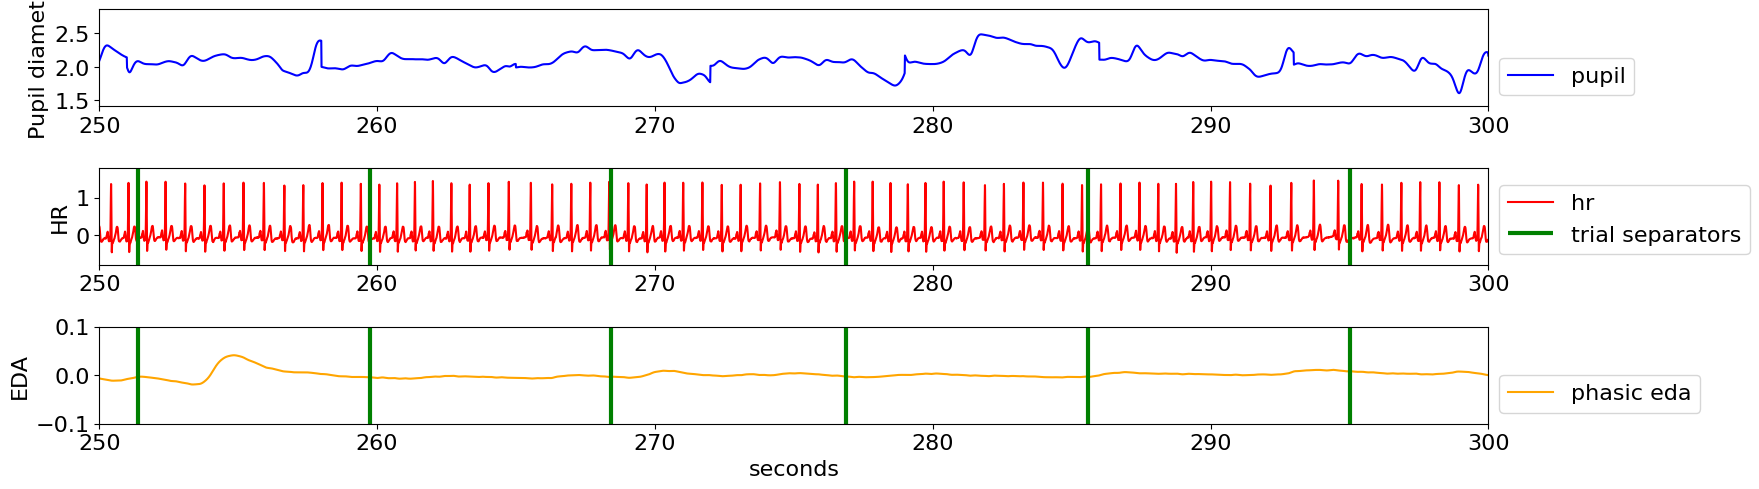

In [23]:
fig, ax = plt.subplots(3)
fig.tight_layout()

ax[0].plot(list(pupil_one_subj.time), list(pupil_one_subj.pupil_diameter),color='blue',label='pupil')
#ax[0].vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[0].set(ylabel='Pupil diameter')
ax[0].set_xlim([250,300])
#ax[0].set_ylim([1.7, 2.3])
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[1].plot(list(eda_hr.time), list(eda_hr.hr),color='red',label='hr')
ax[1].set(ylabel='HR')
ax[1].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[1].legend()
ax[1].set_ylim([-0.8, 1.8])
ax[1].set_xlim([250, 300])
plt.xlabel('seconds')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].plot(list(eda_hr.time), list(eda_hr.phasic),color='orange',label='phasic eda')
ax[2].set(ylabel='EDA')
ax[2].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[2].set_ylim([-0.1, 0.1])
ax[2].set_xlim([250, 300])
plt.show()

In [24]:
eda_subj_1 = modified_eda_by_subject(1)
eda_subj_1

,subject,phasic,phasic_peak,time
0,1,-1.482637e-02,0,-5.000
1,1,-1.492123e-02,0,-4.998
2,1,-1.501798e-02,0,-4.996
3,1,-1.511662e-02,0,-4.994
4,1,-1.521713e-02,0,-4.992
...,...,...,...,...
1421031,1,1.232337e-06,0,2837.062
1421032,1,1.133891e-06,0,2837.064
1421033,1,1.029543e-06,0,2837.066
1421034,1,9.200323e-07,0,2837.068
